In [1]:
import xarray as xr
import xroms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy

# How to select data

The [input/output](io.ipynb) notebook demonstrates how to load in data, but now how to select and slice it apart? Much of this is accomplished with the `sel` and `isel` methods in `xarray`, which are demonstrated in detail in this notebook. 
* Use `sel` to subdivide a Dataset or DataArray by dimension values; the best example of this for ROMS output is selecting certain time using a string representation of a datetime.

    >ds.salt.sel(ocean_time='2010-1-1 12:00')
    
    >ds.salt.sel(ocean_time=slice('2010-1-1', '2010-2-1'))

* Use `isel` to subdivide a Dataset or DataArray by dimension indices:

    >ds.salt.isel(eta_rho=20, xi_rho=100)
    
    >ds.salt.isel(eta_rho=slice(20,100,10), xi_rho=slice(None,None,5))



## `cf-xarray`

`xroms` includes the `cf-xarray` accessor, which allows you to use xarray `sel` and `isel` commands for a DataArray without needing to input the exact grid – just the axes.

With `xarray` alone:

    >ds.salt.isel(xi_rho=20, eta_rho=10, s_rho=20, ocean_time=10)

With `cf-xarray` accessor:

    >ds.salt.cf.isel(X=20, Y=10, Z=20, T=10)
    
and get the same thing back. Same for `sel`. The T, Z, Y, X names can be mixed and matched with the actual dimension names. Some of the attribute wrangling in `xroms` is dedicated to making sure that `cf-xarray` can always identify dimensions and coordinates for DataArrays.

You can always check what `cf-xarray` understands about a Dataset or DataArray with

    ds.salt.cf.describe()

### Load in data

More information at in [input/output notebook](io.ipynb)

In [2]:
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
chunks = {'ocean_time':1}
ds = xroms.open_netcdf(loc, chunks=chunks)

## Select

### Surface layer slice

The surface in ROMS is given by the last index in the vertical dimension. The easiest way to access this is by indexing into `s_rho`. While normally it is better to access coordinates through keywords to be human-readable, it's not easy to tell what value of `s_rho` gives the surface. In this instance, it's easier to just go by index.

In [3]:
ds.salt.isel(s_rho=-1);

# or with cf-xarray accessor:
ds.salt.cf.isel(Z=-1);

### x/y index slice

For a curvilinear ROMS grid, selecting by the dimensions `xi_rho` or `eta_rho` (or for whichever is the relevant grid) is not very meaningful because they are given by index. Thus the following is possible to get a slice along the index, but it cannot be used to find a slice based on the lon/lat values. For the eta and xi grids, `sel` is equivalent to `isel`.

In [4]:
ds.temp.sel(xi_rho=20);

ds.temp.cf.sel(X=20);  # same with cf-xarray accessor

### Single time

Find the forecast model output available that is closest to now. Note that the `method` keyword argument is not necessary if the desired date/time is exactly a model output time. You can daisy-chain together different `sel` and `isel` calls.

In [5]:
now = pd.Timestamp.today()

In [6]:
ds.salt.isel(s_rho=-1).sel(ocean_time=now, method='nearest');

ds.salt.cf.isel(Z=-1).cf.sel(T=now, method='nearest'); 

### Range of time

In [7]:
ds.salt.sel(ocean_time=slice(now, now+pd.Timedelta('2 days')));

ds.salt.cf.sel(T=slice(now, now+pd.Timedelta('2 days'))); 

### Select region

Select a boxed region by min/max lon and lat values.

In [8]:
# want model output only within the box defined by these lat/lon values
lon = np.array([-97, -96])
lat = np.array([28, 29])

In [9]:
# this condition defines the region of interest
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

Plot the model output in the box at the surface

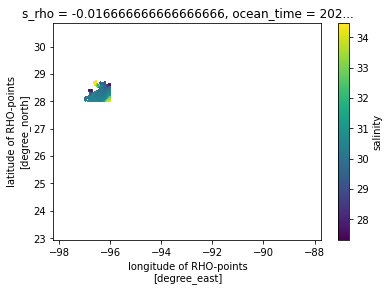

In [10]:
dss = ds.where(box).salt.cf.isel(Z=-1, T=0)
dss.cf.plot(x='longitude', y='latitude')

If you don't need the rest of the model output, you can drop it by using `drop=True` in the `where` call.

/Users/kthyng/opt/miniconda3/envs/XROMS/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


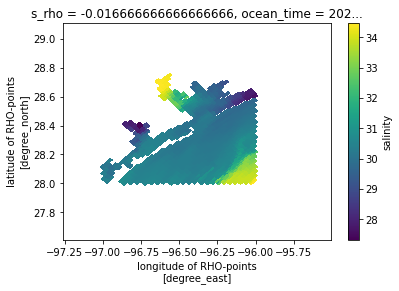

In [11]:
dss = ds.where(box, drop=True).salt.cf.isel(Z=-1, T=0)
dss.cf.plot(x='longitude', y='latitude')

Can calculate a metric within the box:

In [12]:
dss.mean().values

array(30.604784, dtype=float32)

### Find nearest in lon/lat

This matters for a curvilinear grid.

Can't use `sel` because it will only search in one dimension for the nearest value and the dimensions are indices which are not necessarily geographic distance. Instead need to use a search for distance and use that for the `where` condition from the previous example. This functionality has been wrapped into `xroms.sel2d` (and its partner function `xroms.argsel2d`).

In [13]:
lon0, lat0 = -96, 27
saltsel = ds.salt.xroms.sel2d(lon0, lat0)

Or, if you instead want the indices of the nearest grid node returned, you can call `argsel2d`:

In [14]:
ds.salt.xroms.argsel2d(lon0, lat0)

(61, 162)

Check this function, just to be sure:

(26.95, 27.05)

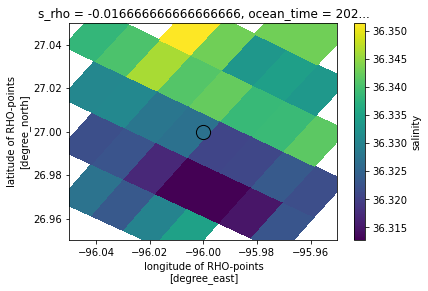

In [15]:
dl = 0.05
box = (ds.lon_rho>lon0-dl) & (ds.lon_rho<lon0+dl) & (ds.lat_rho>lat0-dl) & (ds.lat_rho<lat0+dl)
dss = ds.where(box).salt.cf.isel(T=0, Z=-1)

vmin = dss.min().values
vmax = dss.max().values

dss.plot(x='lon_rho', y='lat_rho')
plt.scatter(lon0, lat0, c=saltsel.cf.isel(Z=-1, T=0), s=200, edgecolor='k', vmin=vmin, vmax=vmax)
plt.xlim(lon0-dl,lon0+dl)
plt.ylim(lat0-dl, lat0+dl)